**All the imports Needed**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
import os

**Reading Data**

In [2]:
data_csv = pd.read_csv("data1.csv")
print(data_csv.head())

                           Quiz Name  Class  ZipGrade ID  External Id  \
0  Level 0 Cluny Convent High School    NaN      5012026          NaN   
1  Level 0 Cluny Convent High School    NaN      5012025          NaN   
2  Level 0 Cluny Convent High School    NaN      5012024          NaN   
3  Level 0 Cluny Convent High School    NaN      5012022          NaN   
4  Level 0 Cluny Convent High School    NaN      5012021          NaN   

   First Name  Last Name  Num Questions  Num Correct  Percent Correct  \
0         NaN        NaN            180           64          35.5556   
1         NaN        NaN            180           60          33.3333   
2         NaN        NaN            180           36          20.0000   
3         NaN        NaN            180           44          24.4444   
4         NaN        NaN            180           60          33.3333   

   Key Version ...   Q36  Q37  Q38  Q39  Q40  Q41  Q42  Q43  Q44  Q45  
0            1 ...     4    0    0    4    0    4 

**Data transposing, skill labelling and difficulty labelling of questions**

In [3]:
questionStartIndex=1
questionEndIndex=45
numQuestions=(questionEndIndex-questionStartIndex+1)
numberOfDifficultyLevels=5.0
if((questionEndIndex-questionStartIndex+1)%numberOfDifficultyLevels!=0):
    print('There is uneven divide in the difficulty levels. Please look into it.')
else:
    print('Each difficulty level has same number of questions.This is nice!')
questionsInEachDifficultyLevel=(questionEndIndex-questionStartIndex+1)/numberOfDifficultyLevels
q_cols = ['Q' + str(i) for i in range(questionStartIndex,questionEndIndex+1)]
answerCols=data_csv[q_cols]
numStudents=answerCols.shape[0]
# correctResponsesForEachQuestion=answerCols.astype(bool).sum(axis=0)
# sortedcorrectResponsesForEachQuestion=correctResponsesForEachQuestion.sort_values(ascending=True)
# sortedcorrectResponsesForEachQuestionDf=sortedcorrectResponsesForEachQuestion.to_frame()
transposed_df=answerCols.transpose()
transposed_df['numCorrect']=transposed_df.astype(bool).sum(axis=1)
transposed_df['qid'] = range(questionStartIndex, questionStartIndex+len(transposed_df))
transposed_df['correctPercentage']=transposed_df['numCorrect']*100.0/numStudents
transposed_df['skillType']=0
transposed_df.loc[(transposed_df['qid']>=1)&(transposed_df['qid']<=10),'skillType' ]=1
transposed_df.loc[(transposed_df['qid']>=11)&(transposed_df['qid']<=20),'skillType' ]=2
transposed_df.loc[(transposed_df['qid']>=21)&(transposed_df['qid']<=30),'skillType' ]=3
transposed_df.loc[(transposed_df['qid']>=31)&(transposed_df['qid']<=40),'skillType' ]=4
transposed_df.loc[(transposed_df['qid']>=41)&(transposed_df['qid']<=45),'skillType' ]=5
colsReqd=['numCorrect','qid','correctPercentage','skillType']
reqdDf=transposed_df[colsReqd].sort_values('correctPercentage',ascending=False)
reqdDf['difficulty_level']=0
for i in range(1,int(numberOfDifficultyLevels+1)):
    reqdDf.iloc[int((i-1)*questionsInEachDifficultyLevel):int((i)*questionsInEachDifficultyLevel),-1]=i

Each difficulty level has same number of questions.This is nice!


**Histogram of Question number to percentage of people who answered it correctly**

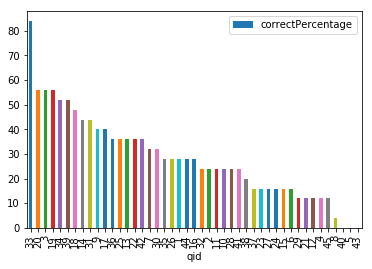

In [4]:
reqdDf.plot(kind='bar',x='qid',y='correctPercentage')

**Table of Question Wise Details ie. percentageCorrectlyAnswered, skill-type and difficulty-level**

In [5]:
print(reqdDf.sort_values('qid'))

     numCorrect  qid  correctPercentage  skillType  difficulty_level
Q1            7    1               28.0          1                 3
Q2            6    2               24.0          1                 3
Q3           14    3               56.0          1                 1
Q4            3    4               12.0          1                 5
Q5            0    5                0.0          1                 5
Q6            4    6               16.0          1                 4
Q7            8    7               32.0          1                 2
Q8            1    8                4.0          1                 5
Q9           10    9               40.0          1                 2
Q10           6   10               24.0          1                 3
Q11           6   11               24.0          2                 3
Q12           3   12               12.0          2                 5
Q13           9   13               36.0          2                 2
Q14          11   14              

**Skill-Wise Difficulty Information**

           difficulty_level  skillType
skillType                             
1                       3.3          1
2                       2.3          2
3                       3.5          3
4                       2.5          4
5                       3.8          5


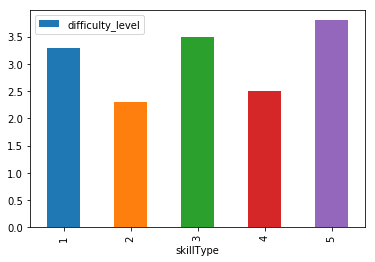

In [6]:
skillDifficultyDf=(reqdDf.groupby(['skillType'])['difficulty_level'].mean()).to_frame()
skillDifficultyDf['skillType']=skillDifficultyDf.index
print(skillDifficultyDf)
skillDifficultyDf.plot(kind='bar',x='skillType',y='difficulty_level')

**End of Task1**

**Start of Task2**

**Assigning Weight to each question as (1-fractionOfPeopleWhoAnsweredCorrectly)**

In [7]:
reqdDf['weight']=1-(reqdDf['correctPercentage']/100)
print(reqdDf.head())

     numCorrect  qid  correctPercentage  skillType  difficulty_level  weight
Q33          21   33               84.0          4                 1    0.16
Q20          14   20               56.0          2                 1    0.44
Q3           14    3               56.0          1                 1    0.44
Q19          14   19               56.0          2                 1    0.44
Q34          13   34               52.0          4                 1    0.48


**Calculating data for each student**

In [27]:
numSkills=5
studentIdArray=data_csv['ZipGrade ID'].values
responsesArray=answerCols.values
dict_correctResponses={}
dict_wrongResponses={}
dict_skill_correct={}
dict_skill_incorrect={}
for c_skillType in range(1,numSkills+1):
    dict_skill_correct[c_skillType]={}
    dict_skill_incorrect[c_skillType]={}
skillWiseScore={}
for t in range(numStudents):
    currStudentId=studentIdArray[t]
    currResponses=responsesArray[t]
    currDf=reqdDf.copy()
    currDf['response']=currResponses
    currDf['qStr']=currDf.index
    correctMask=(currDf['response'].astype(bool)==True)
    incorrectMask=(currDf['response'].astype(bool)==False)
    for c_skillType in range(1,numSkills+1):
        c_skillMask=(currDf['skillType']==c_skillType)
        cs_correctMask = correctMask & c_skillMask
        cs_incorrectMask = incorrectMask & c_skillMask
        dict_skill_correct[c_skillType][currStudentId] =  cs_correctMask.sum()
        dict_skill_incorrect[c_skillType][currStudentId] =  cs_incorrectMask.sum()
    correctlyAnsweredQuestions=currDf['qStr'][correctMask].values
    wronglyAnsweredQuestions=currDf['qStr'][incorrectMask].values
    dict_correctResponses[currStudentId]=correctlyAnsweredQuestions
    dict_wrongResponses[currStudentId]=wronglyAnsweredQuestions
    curr_skill_weight_df=(currDf[correctMask].groupby(['skillType'])['weight'].sum().to_frame())
    for c_skillType in range(1,numSkills+1):
        if(c_skillType not in curr_skill_weight_df.index):
            curr_skill_weight_df.loc[c_skillType] = [0.0]
    skillWiseScore[currStudentId]=(curr_skill_weight_df.reset_index().sort_values('skillType'))['weight'].values

**Relevant data for a student being fetched with student_id**

In [24]:
studentId_whoseInfoIsNeeded=5012012
print('Correctly Answered Questions:',dict_correctResponses[studentId_whoseInfoIsNeeded])
print('Wrongly Answered Questions:',dict_wrongResponses[studentId_whoseInfoIsNeeded])
print('Skill Wise Weighted Scores:',skillWiseScore[studentId_whoseInfoIsNeeded])
print('Total Score:',skillWiseScore[studentId_whoseInfoIsNeeded].sum())

Correctly Answered Questions: ['Q20' 'Q3' 'Q22' 'Q35' 'Q26' 'Q1' 'Q16' 'Q28' 'Q38' 'Q12' 'Q5']
Wrongly Answered Questions: ['Q33' 'Q19' 'Q34' 'Q39' 'Q18' 'Q14' 'Q31' 'Q9' 'Q17' 'Q36' 'Q25' 'Q13'
 'Q42' 'Q7' 'Q30' 'Q44' 'Q32' 'Q2' 'Q11' 'Q10' 'Q41' 'Q37' 'Q23' 'Q27'
 'Q24' 'Q15' 'Q6' 'Q29' 'Q21' 'Q4' 'Q45' 'Q8' 'Q40' 'Q43']
Skill Wise Weighted Scores: [2.16 2.04 2.12 1.52 0.  ]
Total Score: 7.84


**Adding Ranking data for each student for each skill**

In [25]:
studentScoresDf=pd.DataFrame.from_dict(skillWiseScore).transpose()
studentScoresDf.columns = ['score_skill_' + str(i) for i in range(1,numSkills+1)]
studentScoresDf['score_skill_0'] = studentScoresDf.sum(axis=1)
for i in range(numSkills+1):
    studentScoresDf['skill_rank_'+str(i)] = studentScoresDf['score_skill_'+str(i)].rank(ascending=False,method='first')
print(studentScoresDf)

         score_skill_1  score_skill_2  score_skill_3  score_skill_4  \
5012026           3.96           1.72           3.04           2.36   
5012025           1.88           2.92           3.04           1.56   
5012024           1.40           0.52           3.16           1.52   
5012022           1.96           1.20           3.20           0.16   
5012021           1.72           2.36           3.84           2.00   
5012020           1.12           3.48           2.44           1.92   
5012019           2.80           2.00           3.08           1.56   
5012018           0.96           0.64           3.08           0.00   
5012017           0.84           0.76           3.56           1.84   
5012016           2.64           1.60           5.32           3.76   
5012015           2.88           1.48           2.36           2.92   
5012014           2.20           3.08           2.36           1.84   
5012013           1.32           1.36           1.72           1.40   
501201

**Making String for each part which is to be flushed to the pdf**

In [62]:
c_studentId=5012026
lbreak_reportlab='<br/>'
correctAnswerStr='CORRECTLY ANSWERED QUESTIONS'+lbreak_reportlab+lbreak_reportlab+lbreak_reportlab
for q_index in dict_correctResponses[c_studentId]:
    curr_correctPercentage=(reqdDf.loc[q_index,'correctPercentage'])
    curr_weight=(reqdDf.loc[q_index,'weight'])
    correctAnswerStr+='QuestionNumber::'+q_index+lbreak_reportlab
    correctAnswerStr+='CorrectPercentage::'+str(curr_correctPercentage)+lbreak_reportlab
    correctAnswerStr+='ProblemWeight::'+str(curr_weight)+lbreak_reportlab
    correctAnswerStr+=(lbreak_reportlab)

wrongAnswerStr='INCORRECTLY ANSWERED QUESTIONS'+lbreak_reportlab+lbreak_reportlab
for q_index in dict_wrongResponses[c_studentId]:
    curr_correctPercentage=(reqdDf.loc[q_index,'correctPercentage'])
    curr_weight=(reqdDf.loc[q_index,'weight'])
    wrongAnswerStr+='QuestionNumber::'+q_index+lbreak_reportlab
    wrongAnswerStr+='CorrectPercentage::'+str(curr_correctPercentage)+lbreak_reportlab
    wrongAnswerStr+='ProblemWeight::'+str(curr_weight)+lbreak_reportlab
    wrongAnswerStr+=(lbreak_reportlab)  

In [63]:
overallResult="AGGREGATED SUMMARY"+lbreak_reportlab
overallResult+="Student Rank:"+str(studentScoresDf.loc[c_studentId,'skill_rank_0'])+lbreak_reportlab+' Total Score :'+str(studentScoresDf.loc[c_studentId,'score_skill_0'])+lbreak_reportlab

In [68]:
scoreRankStr="SKILL WISE RESULTS"+lbreak_reportlab+lbreak_reportlab+lbreak_reportlab+lbreak_reportlab
for t in range(1,numSkills+1):
    scoreRankStr+= "RESULTS FOR SKILL "+ str(t)+lbreak_reportlab+lbreak_reportlab
    scoreRankStr+="Skill_Rank:"+str(studentScoresDf.loc[c_studentId,'skill_rank_'+str(t)])+lbreak_reportlab
    scoreRankStr+='Skill_Score:'+str(studentScoresDf.loc[c_studentId,'score_skill_'+str(t)])+lbreak_reportlab
    scoreRankStr+='Correctly Answered:'+str(dict_skill_correct[t][c_studentId])+lbreak_reportlab
    scoreRankStr+='InCorrectly Answered:'+str(dict_skill_incorrect[t][c_studentId])+lbreak_reportlab
    scoreRankStr+=lbreak_reportlab+lbreak_reportlab+lbreak_reportlab

**Final Flushing data to the Pdf**

In [69]:
# Sample platypus document
# From the FAQ at reportlab.org/oss/rl-toolkit/faq/#1.1
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.rl_config import defaultPageSize
from reportlab.lib.units import inch

PAGE_HEIGHT=defaultPageSize[1]
PAGE_WIDTH=defaultPageSize[0]
styles = getSampleStyleSheet()
Title = "Student Report__"+str(c_studentId)
pageinfo = c_studentId

def myFirstPage(canvas, doc):
    canvas.saveState()
    canvas.setFont('Times-Bold',16)
    canvas.drawCentredString(PAGE_WIDTH/2.0, PAGE_HEIGHT-108, Title)
    canvas.setFont('Times-Roman',9)
    canvas.drawString(inch, 0.75 * inch,"First Page / %s" % pageinfo)
    canvas.restoreState()
    
def myLaterPages(canvas, doc):
    canvas.saveState()
    canvas.setFont('Times-Roman', 9)
    canvas.drawString(inch, 0.75 * inch,"Page %d %s" % (doc.page, pageinfo))
    canvas.restoreState()
    
def go():
    doc = SimpleDocTemplate("phello.pdf")
    Story = [Spacer(1,2*inch)]
    style = styles["Normal"]
    p = Paragraph(correctAnswerStr, style)
    Story.append(p)
    Story.append(Spacer(1,0.2*inch))
    p = Paragraph(wrongAnswerStr, style)
    Story.append(p)
    Story.append(Spacer(1,0.2*inch))
    
    p = Paragraph(overallResult, style)
    Story.append(p)
    Story.append(Spacer(1,0.2*inch))
    
    p = Paragraph(scoreRankStr, style)
    Story.append(p)
    Story.append(Spacer(1,0.2*inch))
    doc.build(Story, onFirstPage=myFirstPage, onLaterPages=myLaterPages)
    
if __name__ == "__main__":
    go()

**Example of how what type of chart can be inserted for each question**

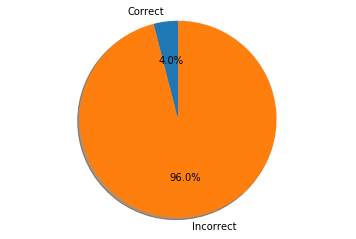

In [72]:
import matplotlib.pyplot as plt

for q_index in dict_correctResponses[c_studentId]:
    curr_correctPercentage=(reqdDf.loc[q_index,'correctPercentage'])
    curr_weight=(reqdDf.loc[q_index,'weight'])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Correct', 'Incorrect'
sizes = [curr_correctPercentage, 100.0-curr_correctPercentage]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()